In [92]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import matplotlib.lines as mlines

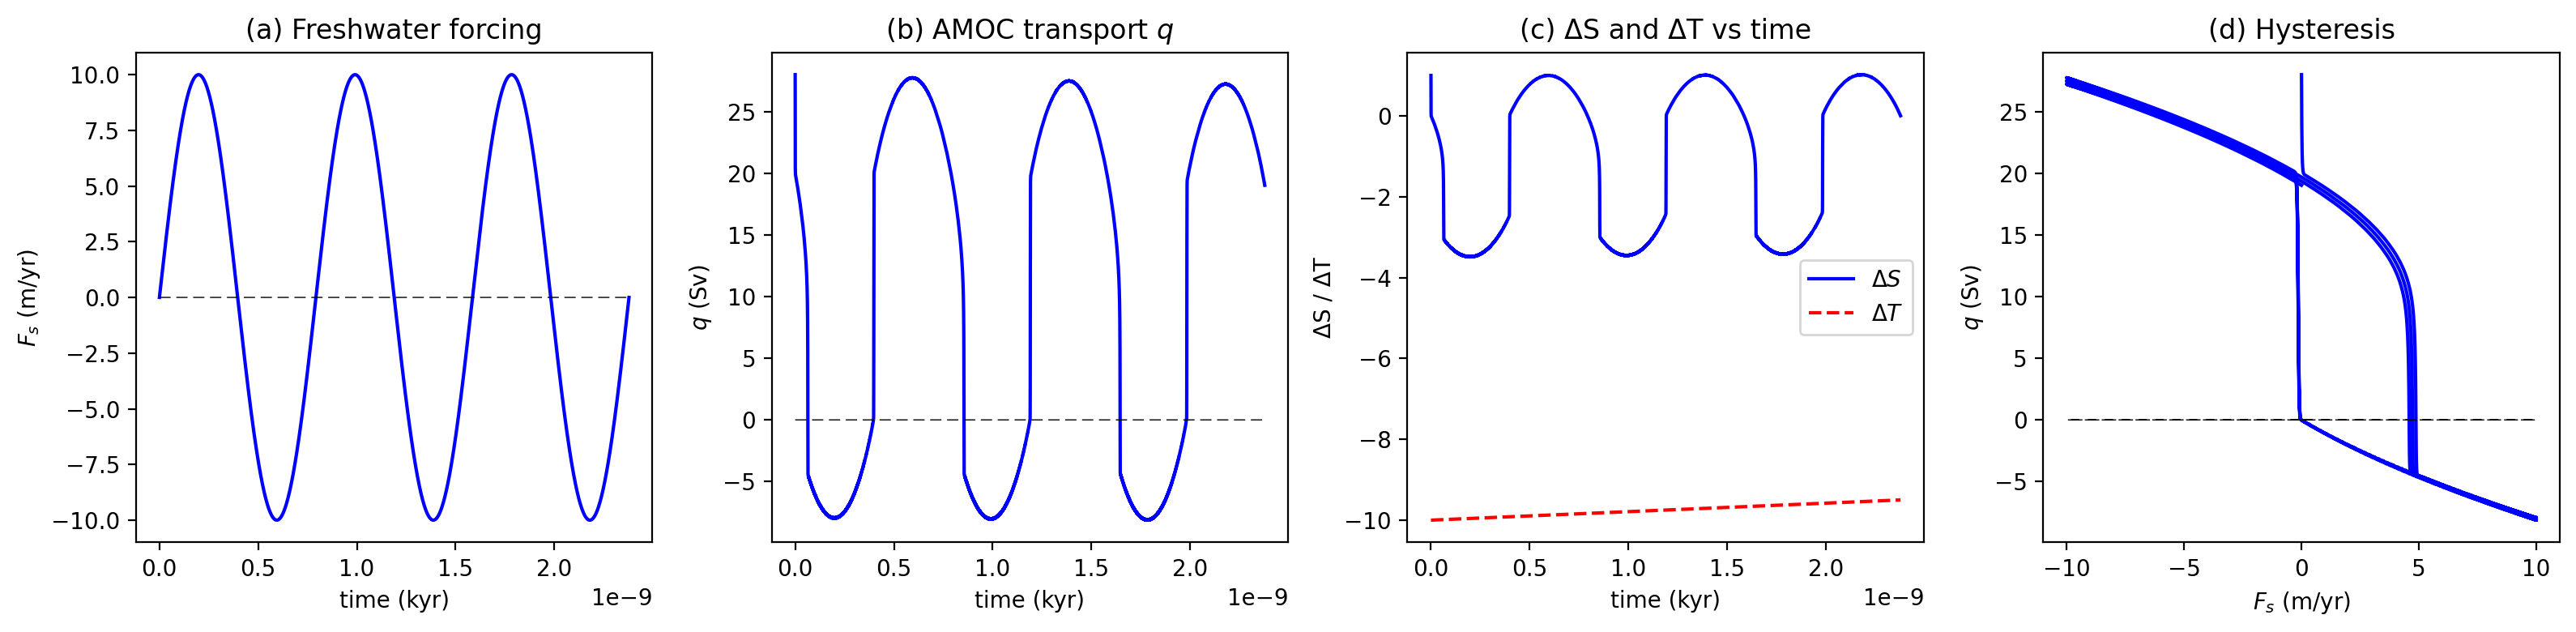

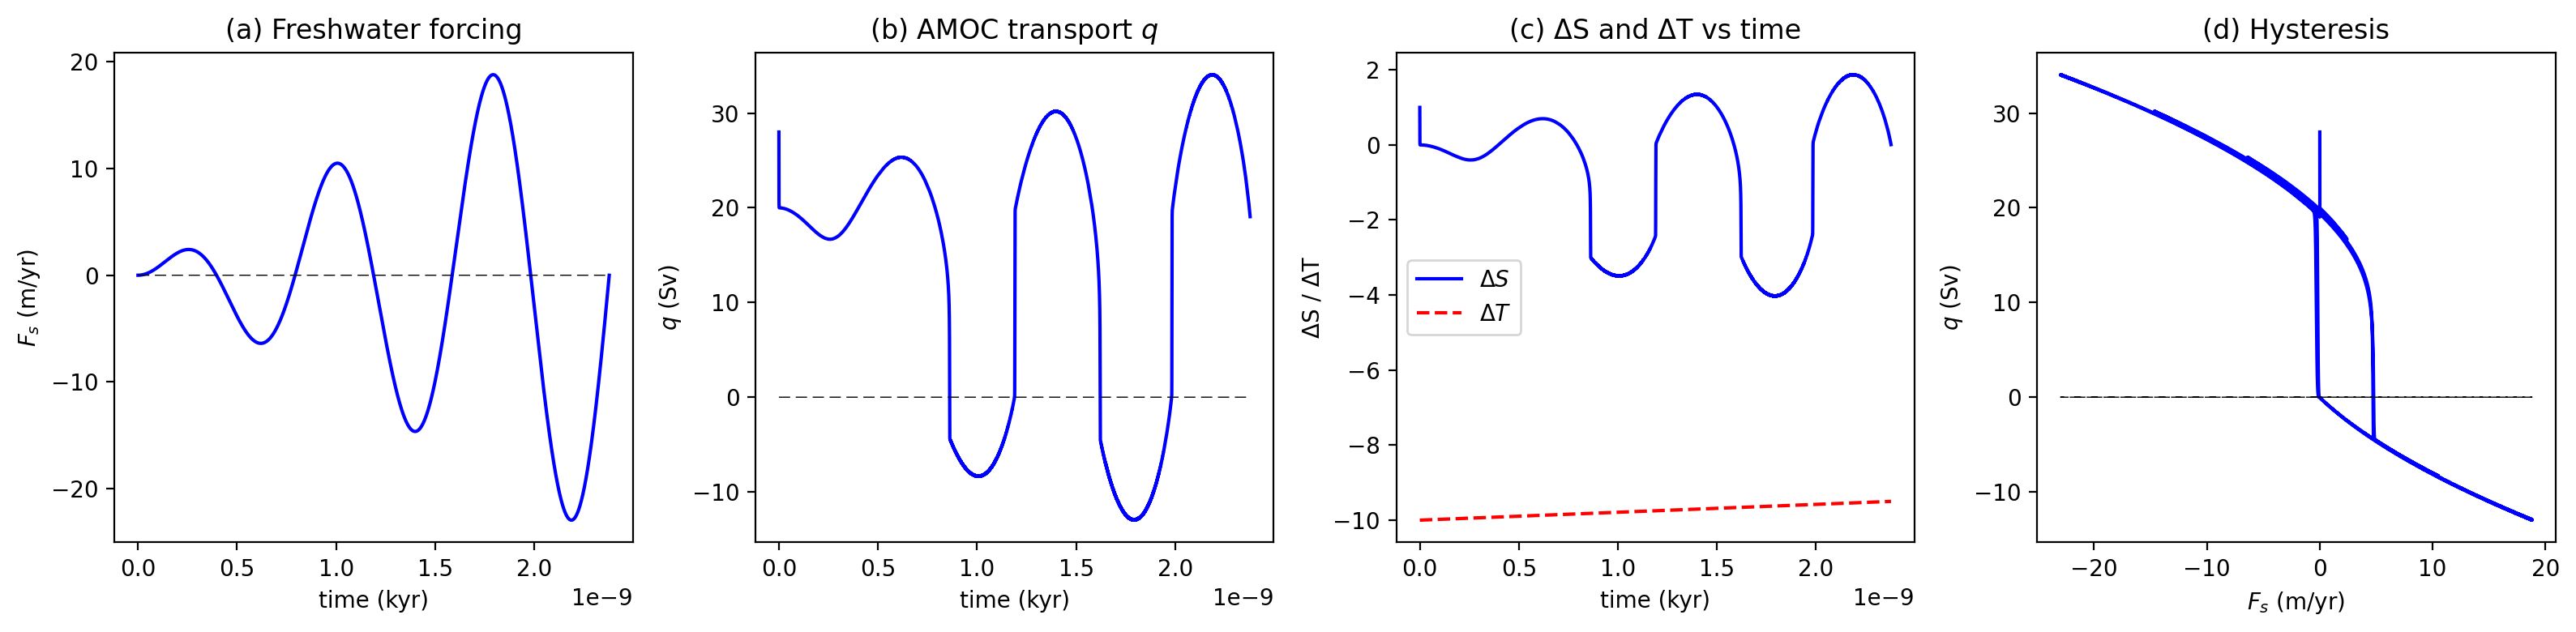

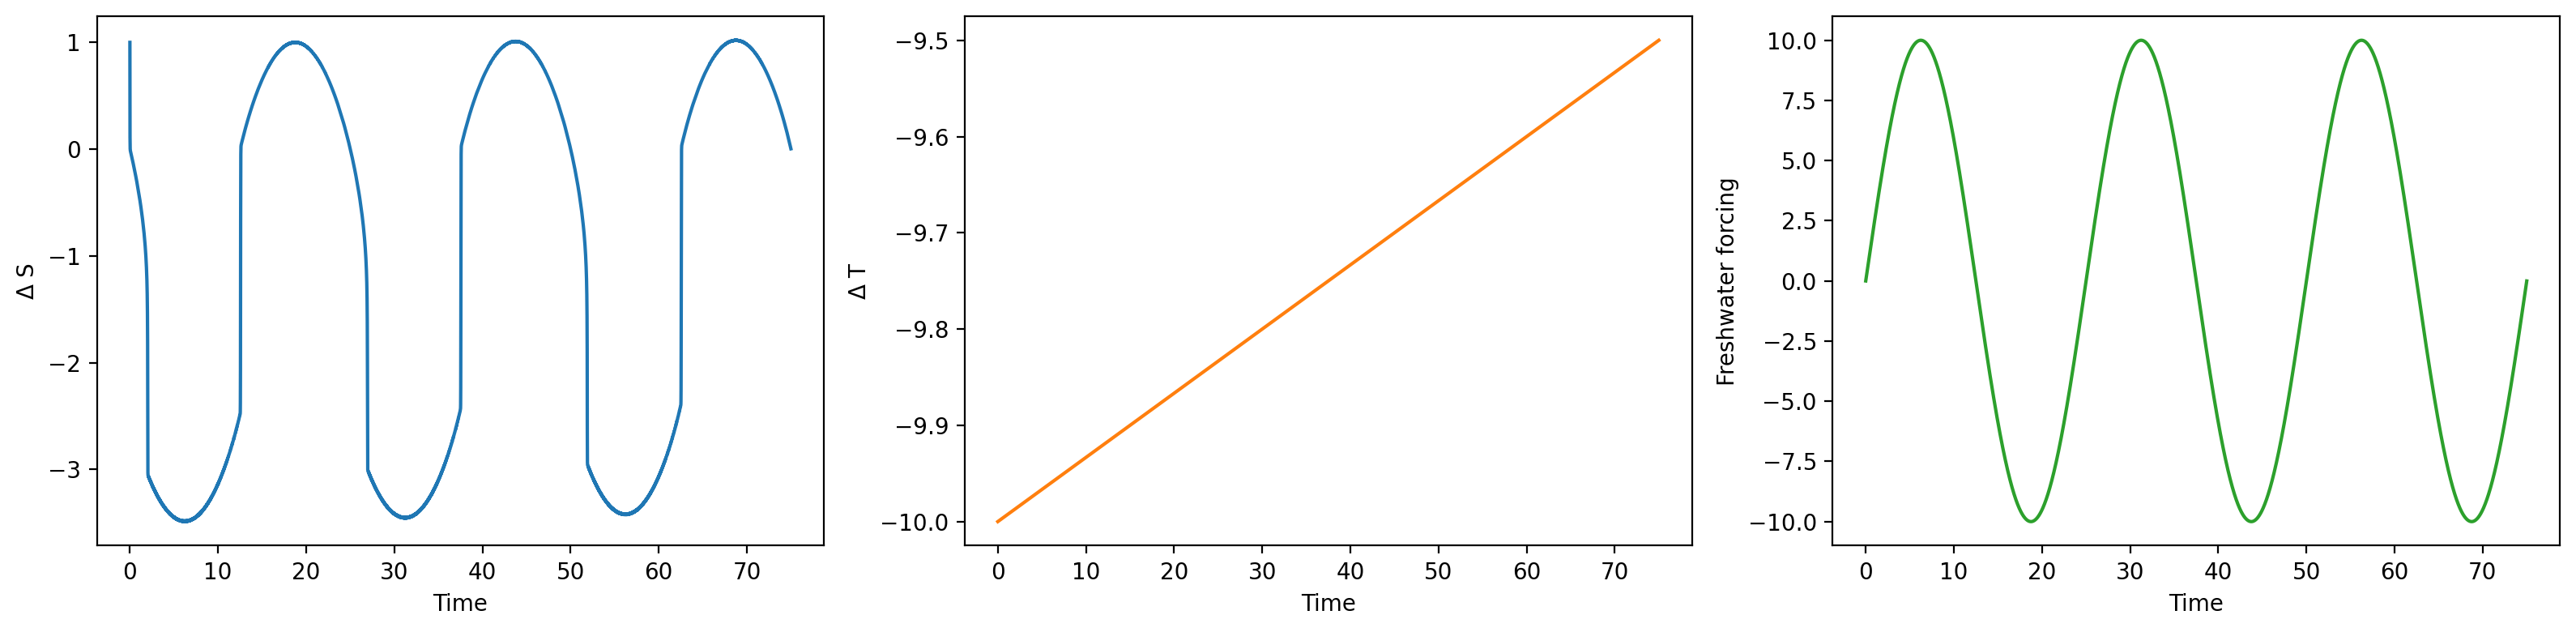

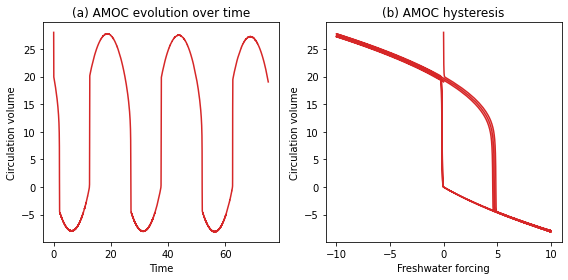

In [93]:
%run 00_generate_data.ipynb

# STATIONARY CASE

In [233]:
input_data, output_data, qplot = get_data("s")

In [234]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

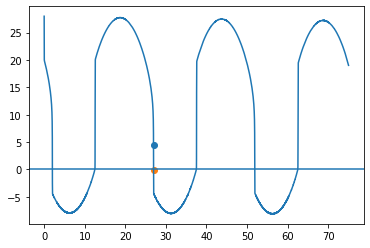

In [235]:
plt.plot(input_data[:, 0], qplot/Sv)
plt.axhline(y=0)
plt.scatter(input_data[35930, 0], qplot[35930]/Sv)
plt.scatter(input_data[35930+16, 0], qplot[35930+16]/Sv)

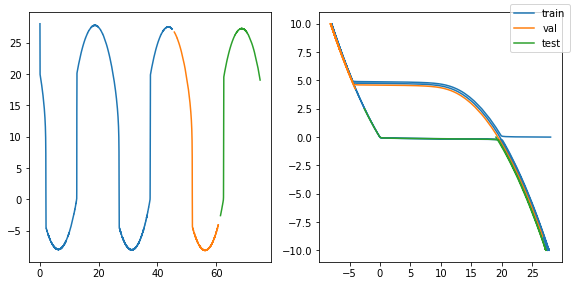

In [236]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(X_train[:, 0], qplot[0:60032]/Sv);
ax[0].plot(X_val[:, 0], qplot[61024:81000]/Sv);
ax[0].plot(X_test[:, 0], qplot[81992:100000]/Sv);
ax[1].plot(qplot[0:60032]/Sv, input_data[:, 3][0:60032]/Fs_to_m_per_year, label='train');
ax[1].plot(qplot[61024:81000]/Sv, input_data[:,3][61024:81000]/Fs_to_m_per_year, label='val');
ax[1].plot(qplot[81992:100000]/Sv, input_data[:, 3][81992:100000]/Fs_to_m_per_year, label='test');
fig.legend();
fig.tight_layout()

In [237]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 16
feature_dim = 4

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [118]:
training_losses = np.zeros(12, dtype=np.ndarray)
validation_losses = np.zeros(12, dtype=np.ndarray)

In [8]:
# training the ensemble 
for i in range(12):
    print(i)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid') 
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_eval = model.fit(X_train_seq, y_train_seq,
                    batch_size=64,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=[es])#,
    training_losses[i] = model_eval.history['loss']
    validation_losses[i] = model_eval.history['val_loss']
    model.save('models/lstm/stationary/ensemble_member_'+str(i)+'.keras')

0
1
2
3
Epoch 10: early stopping
4
5
6
7
8
9
10
Epoch 9: early stopping
11


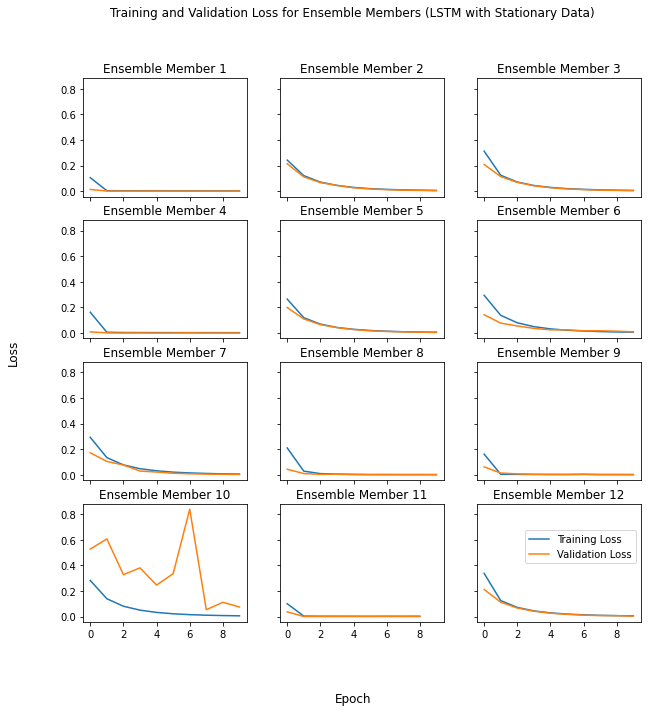

In [9]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10));
fig.supxlabel('Epoch');
fig.supylabel('Loss');
fig.suptitle('Training and Validation Loss for Ensemble Members (LSTM with Stationary Data)');
ax = ax.flatten();
for i in range(12):
    ax[i].plot(training_losses[i], label='Training Loss')
    ax[i].plot(validation_losses[i], label='Validation Loss')
    ax[i].set_title('Ensemble Member ' + str(i+1))
fig.legend(
    labels=['Training Loss', 'Validation Loss'],
    loc='lower right',
    bbox_to_anchor=(0.9, 0.2) 
)
fig.savefig('figures/training/losses_lstm_s.pdf')

In [238]:
accuracies = []
predicted_results_ensemble = np.nan * np.zeros((12, input_seq.shape[0], 1))

for i in range(12):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),   
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid') 
    ])
    model.load_weights('models/lstm/stationary/ensemble_member_'+str(i)+'.keras')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_seq, y_test_seq)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')
    predicted = model.predict(input_seq)
    predicted_results_ensemble[i,...] = predicted

0
563/563 [==============================] - 2s 2ms/step - loss: 0.2495 - accuracy: 0.9257
Test loss: 0.2495279461145401
Test accuracy: 0.925748884677887
3125/3125 [==============================] - 6s 2ms/step
1
563/563 [==============================] - 2s 2ms/step - loss: 0.0646 - accuracy: 0.9804
Test loss: 0.064646877348423
Test accuracy: 0.9803812503814697
3125/3125 [==============================] - 6s 2ms/step
2
563/563 [==============================] - 2s 2ms/step - loss: 0.1238 - accuracy: 0.9547
Test loss: 0.1237546056509018
Test accuracy: 0.9547045826911926
3125/3125 [==============================] - 6s 2ms/step
3
563/563 [==============================] - 2s 2ms/step - loss: 0.0070 - accuracy: 0.9996
Test loss: 0.007022077217698097
Test accuracy: 0.9995554089546204
3125/3125 [==============================] - 5s 2ms/step
4
563/563 [==============================] - 2s 2ms/step - loss: 0.0509 - accuracy: 0.9776
Test loss: 0.05088239908218384
Test accuracy: 0.9776024222373

In [239]:
print('ensemble accuracy: ' + str(sum(accuracies)/12*100))

ensemble accuracy: 96.91407730182013


In [240]:
predicted_results_ensemble.shape

(12, 99985, 1)

In [122]:
input_scaled[15]

array([-1.73115639,  0.74839542, -1.73115639, -0.08088671])

In [123]:
input_seq[0][0]

array([-1.73202196,  1.17737597, -1.73202196, -0.08484775])

In [241]:
predicted_all = np.mean(predicted_results_ensemble, axis=0).reshape(-1)
predicted_labels = (predicted_all > 0.5).astype(int)
false_indices = np.where(predicted_labels != output_seq)

In [214]:
len(false_indices[0])

432

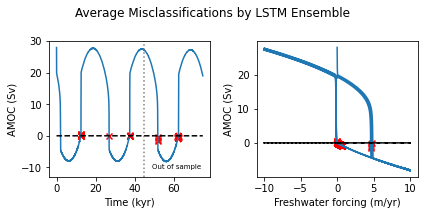

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
split_idx = 60033
split_time = input_data[split_idx, 0]
ax[0].plot(input_data[:, 0], qplot/Sv)
ax[0].plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--')
fig.suptitle('Average Misclassifications by LSTM Ensemble')
ax[0].scatter(input_data[false_indices[0]+15, 0], qplot[false_indices[0]+15]/Sv, marker='x', c='red')
ax[0].set_xlabel('Time (kyr)')
ax[0].set_ylabel('AMOC (Sv)')
ax[0].axvline(x=split_time, linestyle='dotted', color='grey');
ax[0].set_ylim(-13, 30)
ymin, ymax = ax[0].get_ylim();
yloc = ymin + 0.1 * (ymax - ymin);
ax[0].text(split_time + (input_data[-1, 0]-split_time)/1.8, yloc, 
               "Out of sample", ha="center", va="top", fontsize=7, color="black")
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, np.zeros_like(input_data[:, 0]), 'k--')
ax[1].scatter(input_data[false_indices[0]+15, 3]/Fs_to_m_per_year, qplot[false_indices[0]+15]/Sv, marker='x', c='red')
ax[1].set_xlabel('Freshwater forcing (m/yr)')
ax[1].set_ylabel('AMOC (Sv)')
fig.tight_layout()
fig.savefig('figures/training/preds_all_lstm_s.pdf')

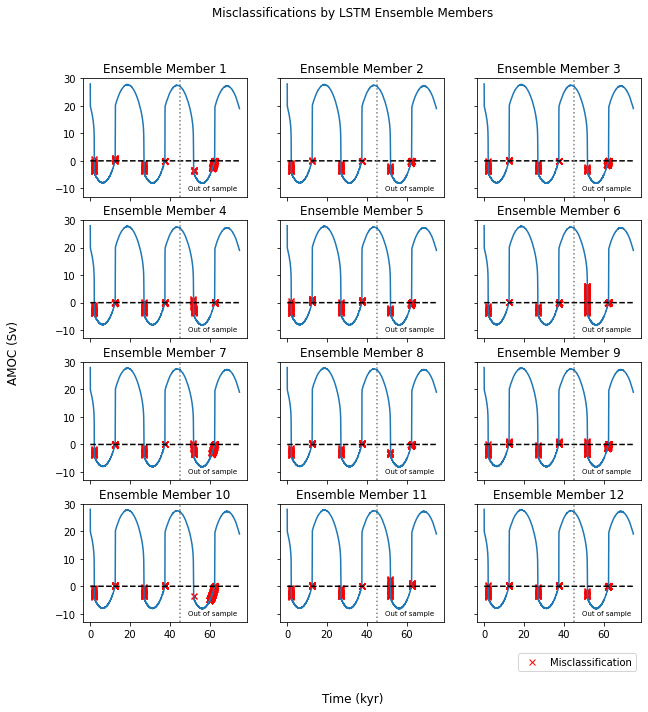

In [219]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Misclassifications by LSTM Ensemble Members')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_data[j]:
            false_indices.append(j+15)
    ax[i].plot(input_data[:, 0], qplot/Sv);
    ax[i].plot(input_data[:, 0], input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
    ax[i].axvline(x=split_time, linestyle='dotted', color='grey');
    ax[i].set_ylim(-13, 30)
    ymin, ymax = ax[i].get_ylim();
    yloc = ymin + 0.1 * (ymax - ymin);
    ax[i].text(split_time + (input_data[-1, 0]-split_time)/1.8, yloc, 
                   "Out of sample", ha="center", va="top", fontsize=7, color="black")
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Misclassification')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_lstm_s_t.pdf')

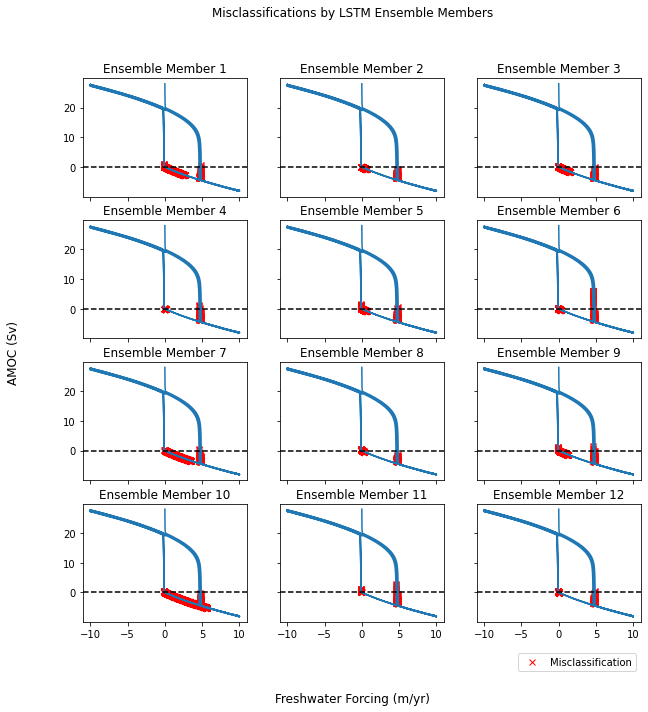

In [242]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Misclassifications by LSTM Ensemble Members')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_data[j]:
            false_indices.append(j+15)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
    ax[i].axhline(0, color='black', linestyle='--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 3][k]/Fs_to_m_per_year for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Misclassification')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_lstm_s_h.pdf')

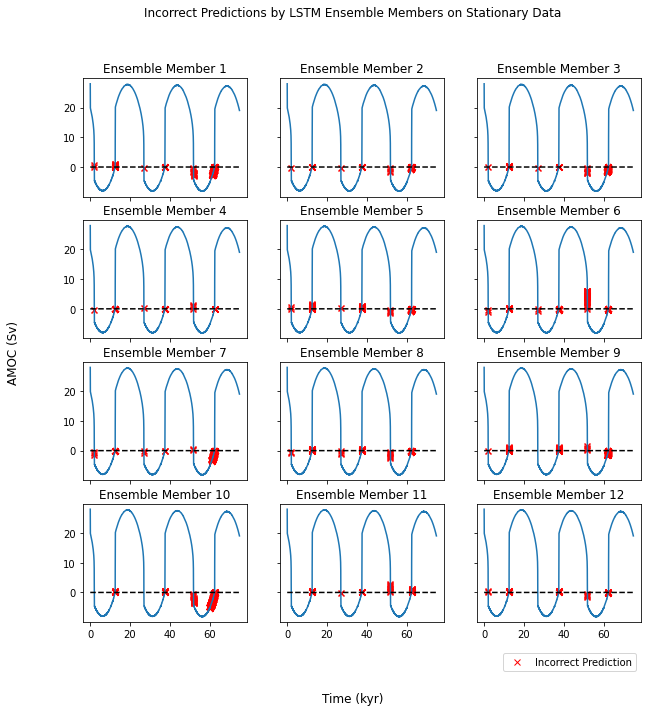

In [136]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by LSTM Ensemble Members on Stationary Data')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_seq[j]:
            false_indices.append(j + 15)
    ax[i].plot(input_data[:, 0], qplot/Sv);
    ax[i].plot(input_data[:, 0], input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Incorrect Prediction')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
#fig.savefig('figures/training/preds_ensemble_lstm_s.pdf')

Text(0, 0.5, 'Circulation (Sv)')

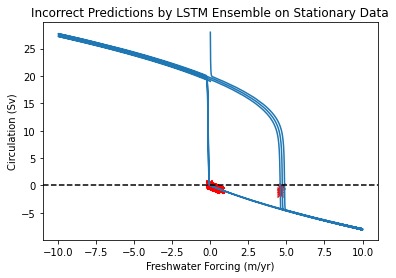

In [145]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Incorrect Predictions by LSTM Ensemble on Stationary Data')
ax.scatter(input_data[false_indices[0] + 15, 3]/Fs_to_m_per_year, qplot[false_indices[0] + 15]/Sv, marker='x', c='red')
ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('Circulation (Sv)')
#fig.savefig('figures/training/preds_all_lstm_s_hysteresis.pdf')

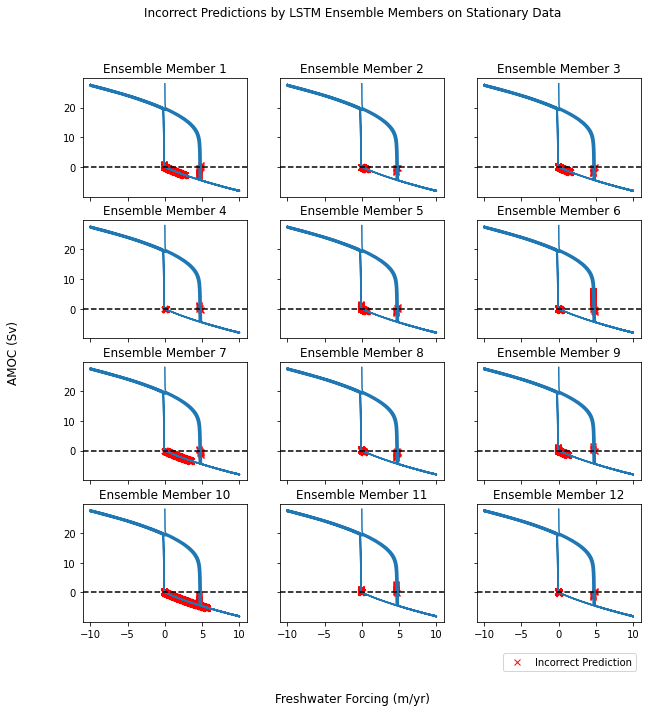

In [146]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by LSTM Ensemble Members on Stationary Data')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_seq[j]:
            false_indices.append(j + 15)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
    ax[i].axhline(0, color='black', linestyle='--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 3][k]/Fs_to_m_per_year for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Incorrect Prediction')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
#fig.savefig('figures/training/preds_ensemble_lstm_s_hysteresis.pdf')

# NONSTATIONARY CASE

In [221]:
input_data, output_data, qplot = get_data("ns")

In [222]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

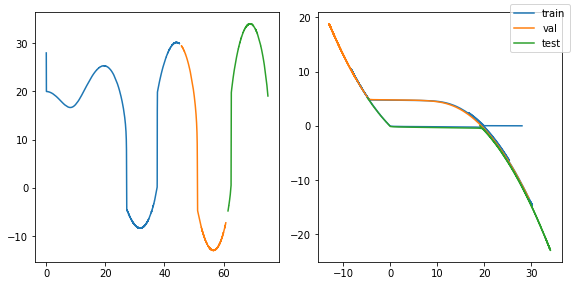

In [223]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(X_train[:, 0], qplot[0:60032]/Sv);
ax[0].plot(X_val[:, 0], qplot[61024:81000]/Sv);
ax[0].plot(X_test[:, 0], qplot[81992:100000]/Sv);
ax[1].plot(qplot[0:60032]/Sv, input_data[:, 3][0:60032]/Fs_to_m_per_year, label='train');
ax[1].plot(qplot[61024:81000]/Sv, input_data[:,3][61024:81000]/Fs_to_m_per_year, label='val');
ax[1].plot(qplot[81992:100000]/Sv, input_data[:, 3][81992:100000]/Fs_to_m_per_year, label='test');
fig.legend();
fig.tight_layout()

In [224]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 32
feature_dim = 4

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [28]:
training_losses = np.zeros(12, dtype=np.ndarray)
validation_losses = np.zeros(12, dtype=np.ndarray)

In [29]:
# training the ensemble 
for i in range(12):
    print(i)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid') 
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_eval = model.fit(X_train_seq, y_train_seq,
                    batch_size=64,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=[es])#,
    training_losses[i] = model_eval.history['loss']
    validation_losses[i] = model_eval.history['val_loss']
    model.save('models/lstm/nonstationary/ensemble_member_'+str(i)+'.keras')

0
Epoch 6: early stopping
1
2
3
4
5
6
7
Epoch 10: early stopping
8
Epoch 6: early stopping
9
10
11
Epoch 8: early stopping


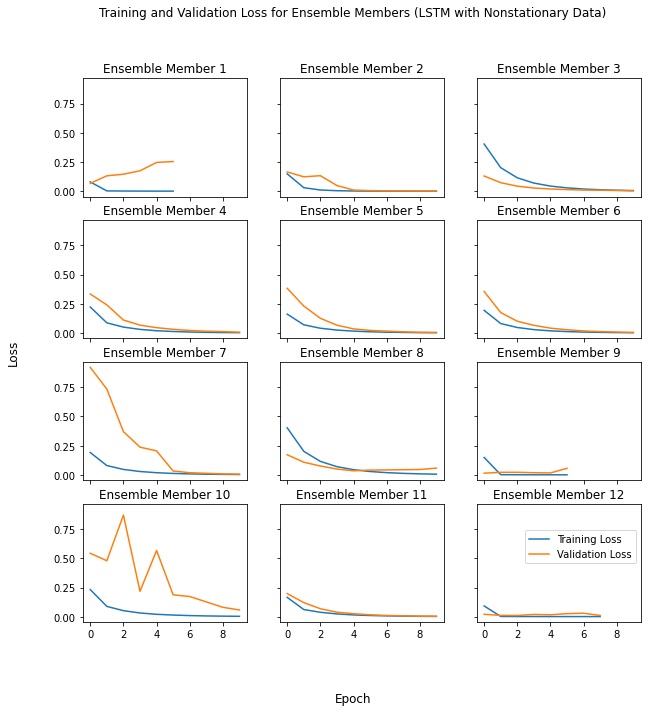

In [37]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10));
fig.supxlabel('Epoch');
fig.supylabel('Loss');
fig.suptitle('Training and Validation Loss for Ensemble Members (LSTM with Nonstationary Data)');
ax = ax.flatten();
for i in range(12):
    ax[i].plot(training_losses[i], label='Training Loss')
    ax[i].plot(validation_losses[i], label='Validation Loss')
    ax[i].set_title('Ensemble Member ' + str(i+1))
fig.legend(
    labels=['Training Loss', 'Validation Loss'],
    loc='lower right',
    bbox_to_anchor=(0.9, 0.2) 
)
fig.savefig('figures/training/losses_lstm_ns.pdf')

In [225]:
accuracies = []
predicted_results_ensemble = np.nan * np.zeros((12, input_seq.shape[0], 1))

for i in range(12):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid') 
    ])
    model.load_weights('models/lstm/nonstationary/ensemble_member_'+str(i)+'.keras')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_seq, y_test_seq)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')
    predicted = model.predict(input_seq)
    predicted_results_ensemble[i,...] = predicted

0
562/562 [==============================] - 2s 2ms/step - loss: 0.1448 - accuracy: 0.9267
Test loss: 0.14476558566093445
Test accuracy: 0.9267397522926331
3125/3125 [==============================] - 8s 2ms/step
1
562/562 [==============================] - 2s 2ms/step - loss: 0.2058 - accuracy: 0.9267
Test loss: 0.20577582716941833
Test accuracy: 0.9267397522926331
3125/3125 [==============================] - 7s 2ms/step
2
562/562 [==============================] - 2s 2ms/step - loss: 0.3734 - accuracy: 0.9267
Test loss: 0.3734475374221802
Test accuracy: 0.9267397522926331
3125/3125 [==============================] - 6s 2ms/step
3
562/562 [==============================] - 2s 2ms/step - loss: 0.0952 - accuracy: 0.9790
Test loss: 0.09524605423212051
Test accuracy: 0.9789731502532959
3125/3125 [==============================] - 6s 2ms/step
4
562/562 [==============================] - 2s 2ms/step - loss: 0.0069 - accuracy: 0.9975
Test loss: 0.0068715158849954605
Test accuracy: 0.99749678

In [226]:
print('ensemble accuracy: ' + str(sum(accuracies)/12*100))

ensemble accuracy: 95.33848911523819


In [227]:
predicted_results_ensemble.shape

(12, 99969, 1)

In [228]:
predicted_all = np.mean(predicted_results_ensemble, axis=0).reshape(-1)
predicted_labels = (predicted_all > 0.5).astype(int)
false_indices = np.where(predicted_labels != output_seq)

In [41]:
test_indices = set(range(81992, 100000))
wrong_in_test = list(set(false_indices[0]) & test_indices)
np.save('incorrect_indices_lstm_ns', np.array(wrong_in_test))

In [229]:
false_indices

(array([36206, 49982, 49983, ..., 83306, 83307, 83308]),)

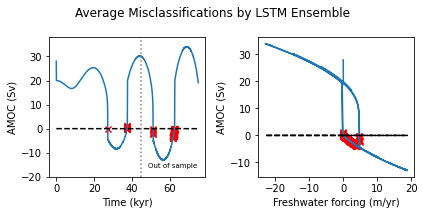

In [230]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
split_idx = 60033
split_time = input_data[split_idx, 0]
ax[0].plot(input_data[:, 0], qplot/Sv)
ax[0].plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--')
fig.suptitle('Average Misclassifications by LSTM Ensemble')
ax[0].scatter(input_data[false_indices[0]+31, 0], qplot[false_indices[0]+31]/Sv, marker='x', c='red')
ax[0].set_xlabel('Time (kyr)')
ax[0].set_ylabel('AMOC (Sv)')
ax[0].axvline(x=split_time, linestyle='dotted', color='grey');
ax[0].set_ylim(-20, 38)
ymin, ymax = ax[0].get_ylim();
yloc = ymin + 0.1 * (ymax - ymin);
ax[0].text(split_time + (input_data[-1, 0]-split_time)/1.8, yloc, 
               "Out of sample", ha="center", va="top", fontsize=7, color="black")
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, np.zeros_like(input_data[:, 0]), 'k--')
ax[1].scatter(input_data[false_indices[0]+31, 3]/Fs_to_m_per_year, qplot[false_indices[0]+31]/Sv, marker='x', c='red')
ax[1].set_xlabel('Freshwater forcing (m/yr)')
ax[1].set_ylabel('AMOC (Sv)')
fig.tight_layout()
fig.savefig('figures/training/preds_all_lstm_ns.pdf')

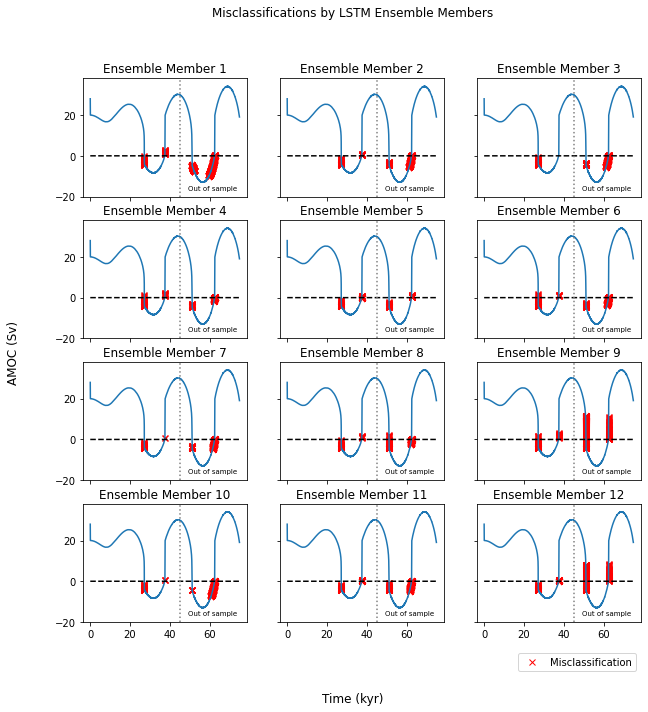

In [231]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Misclassifications by LSTM Ensemble Members')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_data[j]:
            false_indices.append(j+31)
    ax[i].plot(input_data[:, 0], qplot/Sv);
    ax[i].plot(input_data[:, 0], input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
    ax[i].axvline(x=split_time, linestyle='dotted', color='grey');
    ax[i].set_ylim(-20, 38)
    ymin, ymax = ax[i].get_ylim();
    yloc = ymin + 0.1 * (ymax - ymin);
    ax[i].text(split_time + (input_data[-1, 0]-split_time)/1.8, yloc, 
                   "Out of sample", ha="center", va="top", fontsize=7, color="black")
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Misclassification')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_lstm_ns_t.pdf')

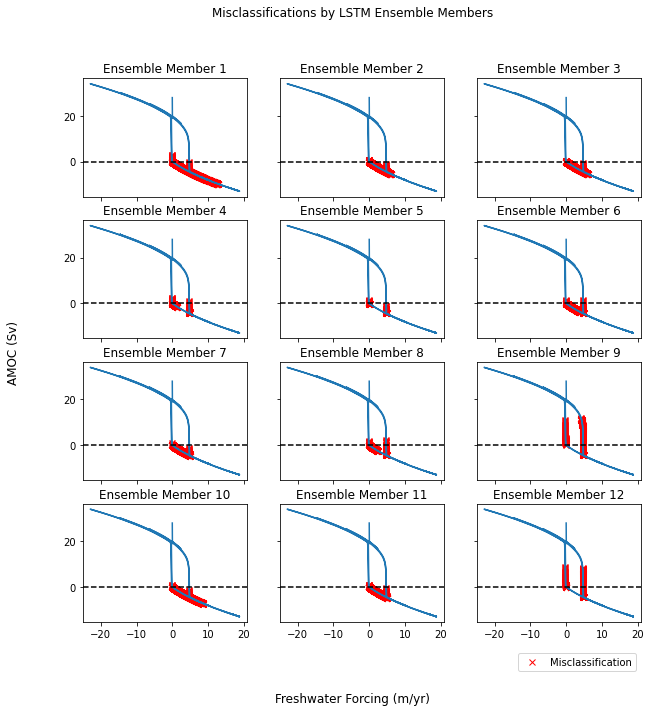

In [232]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Misclassifications by LSTM Ensemble Members')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_data[j]:
            false_indices.append(j+31)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
    ax[i].axhline(0, color='black', linestyle='--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 3][k]/Fs_to_m_per_year for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Misclassification')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_lstm_ns_h.pdf')

In [72]:
input_seq[0][-1]

array([-1.73115639,  0.74839542, -1.73115639, -0.08088671])

In [73]:
input_scaled[15]

array([-1.73115639,  0.74839542, -1.73115639, -0.08088671])

In [75]:
output_seq[0]

1

In [67]:
false_indices

(array([16664, 16665, 16666, 16667, 16668, 16669, 16670, 16671, 16672,
        16673, 16674, 16675, 16676, 16677, 16678, 16679, 16680, 16681,
        16682, 16683, 16684, 16685, 16686, 16687, 16688, 16689, 16690,
        16691, 16692, 35931, 49991, 49992, 49993, 49994, 49995, 49996,
        49997, 49998, 49999, 50000, 50001, 50002, 50003, 50004, 50005,
        50006, 50007, 69178, 69179, 69180, 69181, 82947, 82948, 82949,
        82950, 82951, 82952, 82953, 82954, 82955, 82956, 82957, 82958,
        82959, 82960, 82961, 82962, 82963, 82964, 82965, 82966, 82967,
        82968, 82969, 82970, 82971, 82972, 82973, 82974, 82975, 82976,
        82977, 82978, 82979, 82980, 82981, 82982, 82983, 82984, 82985,
        82986, 82987, 82988, 82989, 82990, 82991, 82992, 82993, 82994,
        82995, 82996, 82997, 82998, 82999, 83000, 83001, 83002, 83003,
        83004, 83005, 83006, 83007, 83008, 83009, 83010, 83011, 83012,
        83013, 83014, 83015, 83016, 83017, 83018, 83019, 83020, 83021,
      

In [87]:
[1, 2, 3] + (15)

TypeError: 'int' object is not iterable

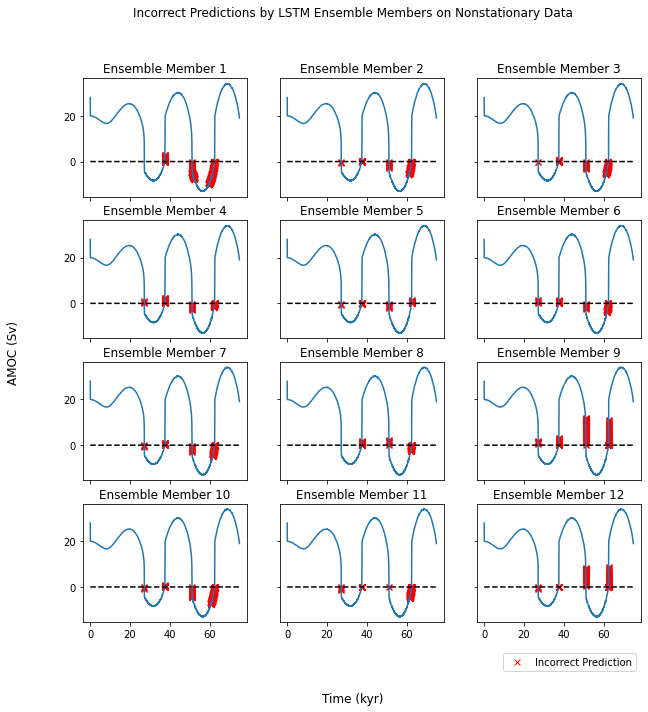

In [183]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by LSTM Ensemble Members on Nonstationary Data')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_seq[j]:
            false_indices.append(j+31)
    ax[i].plot(input_data[:, 0], qplot/Sv);
    ax[i].plot(input_data[:, 0], input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Incorrect Prediction')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
#fig.savefig('figures/training/preds_ensemble_lstm_ns.pdf')

Text(0, 0.5, 'Circulation (Sv)')

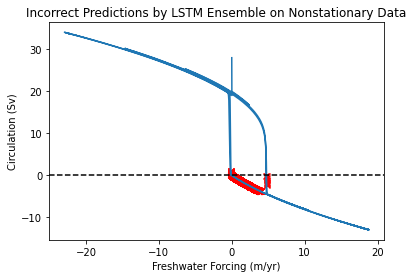

In [192]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax.axhline(0, color='black', linestyle='--');
ax.set_title('Incorrect Predictions by LSTM Ensemble on Nonstationary Data')
ax.scatter(input_data[false_indices[0]+31, 3]/Fs_to_m_per_year, qplot[false_indices[0]+31]/Sv, marker='x', c='red')
ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('Circulation (Sv)')
#fig.savefig('figures/training/preds_all_lstm_ns_hysteresis.pdf')

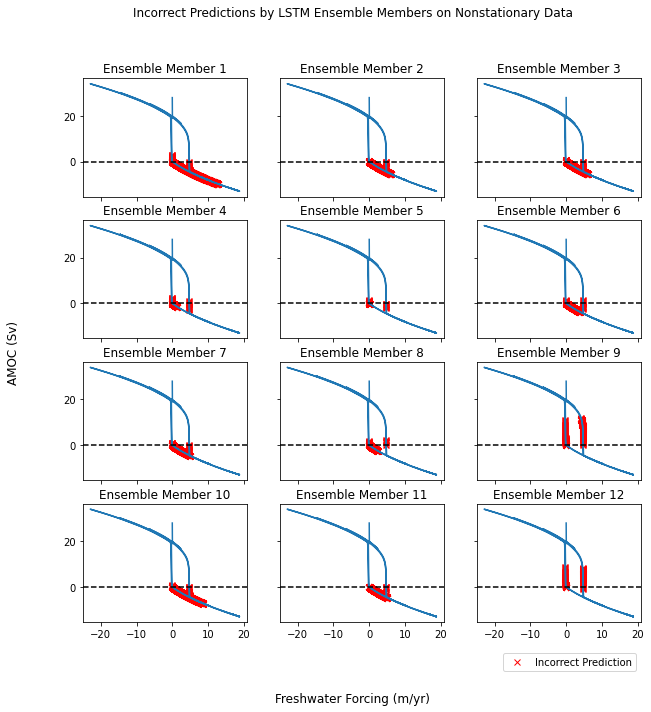

In [193]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by LSTM Ensemble Members on Nonstationary Data')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_seq[j]:
            false_indices.append(j+31)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
    ax[i].axhline(0, color='black', linestyle='--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 3][k]/Fs_to_m_per_year for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Incorrect Prediction')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
#fig.savefig('figures/training/preds_ensemble_lstm_ns_hysteresis.pdf')

In [202]:
input_seq[0][-1]

array([-1.73023312,  0.37219722, -1.73023312,  0.08299029])

In [205]:
input_scaled[31]

array([-1.73023312,  0.37219722, -1.73023312,  0.08299029])